In [84]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

%run '../functions.py'
%run '../classes.py'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adammajczyk/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/adammajczyk/nltk_data..

In [86]:
save_path = 'grid_search_results_new.json'
grids_path = '../grid_search_grids.json'

In [87]:
model_w2v_settings = return_best_model()

In [88]:
model_w2v_settings['model_path'] = '../all_datasets/' + model_w2v_settings['model_path']

model_w2v = Word2VecModel(model_w2v_settings)

In [ ]:
# read preprocessed data from pickle file
df = pd.read_pickle('data/preprocessed_titles_labels.pkl')
df.head()

In [90]:
df['sample'].value_counts()


sample
train    28836
test      1607
val2       781
val1       776
Name: count, dtype: int64

In [ ]:
# split data into train and test stratified by y
from sklearn.preprocessing import StandardScaler
import os
import pickle

df['title_vector'] = [get_word_vectors(model_w2v, title, aggregation='mean') for title in df['title']]
df = df.reset_index(drop=True)
df.head()

In [92]:
df['title_vector'][0]

array([-0.63768053, -0.16730867,  1.2560811 ,  0.3338902 , -0.56454986,
        0.44497627,  0.784385  ,  0.3551108 , -0.8828402 ,  0.59592795,
        0.1280393 , -0.64912486,  0.81945324, -0.3996215 ,  0.32769346,
        1.2330511 ,  0.67513835, -0.43883395,  0.24185432, -0.9126102 ],
      dtype=float32)

In [93]:
variables_to_drop = get_dimensions_to_drop()
variables_to_drop

[16, 14, 2, 11, 10, 6, 15, 18, 12, 8, 13, 3, 1, 4, 17, 19, 9, 0]

In [94]:
df['title_vector'] = [drop_dimensions_from_vector(vector, variables_to_drop) for vector in df['title_vector']]

In [95]:
df['title_vector'][0]

array([0.44497627, 0.3551108 ], dtype=float32)

In [96]:
X_train = np.vstack(df[df['sample']=='train']['title_vector'])
X_test = np.vstack(df[df['sample']=='val2']['title_vector'])

y_train = df[df['sample']=='train']['is_clickbait']
y_test = df[df['sample']=='val2']['is_clickbait']

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import json

with open(grids_path, 'r') as f:
    model_settings = json.load(f)

model_settings
grids = model_settings['grid_search_grids']
grids

In [98]:
models_to_CV = list()

for model_name, grid in grids.items():
    # check if model has already been trained - if 'best_params' exists in grid
    if 'best_params' in grid.keys():
        print(f'Model {model_name} already trained')
        continue
    models_to_CV.append((model_name))
models_to_CV

# remove _grid from model names
models_to_CV = [model_name.replace('_grid', '') for model_name in models_to_CV]
models_to_CV

['decision_tree', 'catboost', 'lightgbm', 'xgboost', 'random_forest']

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [100]:
def return_model_with_param(model_name, param = dict()):
    if model_name == 'decision_tree':
        model = DecisionTreeClassifier(**param)
    elif model_name == 'random_forest':
        model = RandomForestClassifier(**param)
    elif model_name == 'xgboost':
        model = XGBClassifier(**param)
    elif model_name == 'lightgbm':
        model = LGBMClassifier(**param, verbose=-1)
    elif model_name == 'catboost':
        model = CatBoostClassifier(**param,verbose=0)
    return model

In [101]:
models_to_CV = [
    'catboost',
    'lightgbm', 
    'xgboost',
    
    'decision_tree', 
    'random_forest',  
    
]

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from tqdm.notebook import tqdm

# read existing results
try:
    with open(save_path, 'r') as f:
        grid_search_results = json.load(f)
    print('Loaded existing results')
except:
    grid_search_results = dict()
    print('No existing results found - creating new dict')
for model_name in models_to_CV:
    grid_search_results[model_name] = dict()

for model_name in tqdm(models_to_CV, desc = 'Models'):

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # get grid
    grid = grids[model_name+'_grid']

    # generate all combinations of parameters
    import itertools

    keys, values = zip(*grid.items())
    combinations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # do grid search
    
    for params in combinations_dicts:
        grid_search_results[model_name][str(params)] = dict()

    for params in tqdm(combinations_dicts, desc = 'Grid combinations search for model {}'.format(model_name)):
       
        model = return_model_with_param(model_name, params)
        scores_auc_cv_val = list()
        scores_auc_val2 = list()
        scores_auc_train = list()

        scores_f1_cv_val = list()
        scores_f1_val2 = list()
        scores_f1_train = list()

        for train_index, val_index in kf.split(X_train_scaled, y_train):
            X_train_kf = X_train_scaled[train_index]
            X_val_kf = X_train_scaled[val_index]
            y_train_kf = y_train.iloc[train_index]
            y_val_kf = y_train.iloc[val_index]

            model.fit(X_train_kf, y_train_kf)

            # print(model)

        
            scores_auc_cv_val.append(roc_auc_score(y_val_kf, model.predict_proba(X_val_kf)[:,1]))
            scores_auc_val2.append(roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))
            scores_auc_train.append(roc_auc_score(y_train_kf, model.predict_proba(X_train_kf)[:,1]))

            y_pred_cv_val = model.predict_proba(X_val_kf)[:,1]
            y_pred_val2 = model.predict_proba(X_test_scaled)[:,1]
            y_pred_train = model.predict_proba(X_train_kf)[:,1]

            # print(y_pred_cv_val[y_pred_cv_val>0.5])

            y_pred_cv_val = np.where(y_pred_cv_val > 0.5, 1, 0)
            y_pred_val2 = np.where(y_pred_val2 > 0.5, 1, 0)
            y_pred_train = np.where(y_pred_train > 0.5, 1, 0)


            
            scores_f1_cv_val.append(f1_score(y_val_kf, model.predict(X_val_kf)))
            scores_f1_val2.append(f1_score(y_test, model.predict(X_test_scaled)))
            scores_f1_train.append(f1_score(y_train_kf, model.predict(X_train_kf)))
            break

        # print(scores_f1_train, scores_f1_cv_val, scores_f1_val2)
        # print(scores_auc_train, scores_auc_cv_val, scores_auc_val2)

        grid_search_results[model_name][str(params)]['mean_train_f1'] = np.mean(scores_f1_train)
        grid_search_results[model_name][str(params)]['mean_cv_val_f1'] = np.mean(scores_f1_cv_val)
        grid_search_results[model_name][str(params)]['mean_val2_f1'] = np.mean(scores_f1_val2)

        grid_search_results[model_name][str(params)]['mean_train_auc'] = np.mean(scores_auc_train)
        grid_search_results[model_name][str(params)]['mean_cv_val_auc'] = np.mean(scores_auc_cv_val)
        grid_search_results[model_name][str(params)]['mean_val2_auc'] = np.mean(scores_auc_val2)

        grid_search_results[model_name][str(params)]['f1_diff_cv_val'] = np.mean(scores_f1_train) - np.mean(scores_f1_cv_val)
        grid_search_results[model_name][str(params)]['auc_diff_cv_val'] = np.mean(scores_auc_train) - np.mean(scores_auc_cv_val)

        grid_search_results[model_name][str(params)]['f1_diff_val2'] = np.mean(scores_f1_train) - np.mean(scores_f1_val2)
        grid_search_results[model_name][str(params)]['auc_diff_val2'] = np.mean(scores_auc_train) - np.mean(scores_auc_val2)

        grid_search_results[model_name][str(params)]['params'] = params

        # save results to json file
        with open(save_path, 'w') as f:
            json.dump(grid_search_results, f)
    



    print(grid_search_results[model_name])
    
# grid_search_results

In [103]:
# save results
with open(save_path, 'w') as f:
    json.dump(grid_search_results, f)

In [104]:
# load results
with open(save_path, 'r') as f:
    grid_search_results = json.load(f)

In [105]:
df_res= pd.DataFrame()

for model in grid_search_results:
    temp = grid_search_results[model]
    temp = pd.DataFrame.from_dict(temp)
    temp = temp.transpose()
    temp['model'] = model
    df_res = pd.concat([df_res, temp])

In [106]:
df_res = df_res.reset_index()

In [ ]:
top_auc = df_res[(df_res['auc_diff_val2']<=0.05)].sort_values(by='mean_val2_auc', ascending=False).head(500)
top_auc

In [ ]:
topf1 = df_res[(df_res['f1_diff_val2']<=0.05)].sort_values(by='mean_val2_f1', ascending=False).head(500)
topf1

In [109]:
top_both = pd.merge(top_auc, topf1, on=['index'], how='inner')

# keep _x columns
top_both = top_both[[col for col in top_both.columns if '_x' in col]]
top_both.columns = [col.replace('_x', '') for col in top_both.columns]

In [ ]:
top_both['sum_diff_val2'] = top_both['f1_diff_val2'] + top_both['auc_diff_val2']
top_both['sum_auc_f1_val2'] = top_both['mean_val2_f1'] + top_both['mean_val2_auc']

top_both = top_both.sort_values(by='sum_auc_f1_val2', ascending=False).head(1000).reset_index(drop=True)
top_both

In [111]:
params, model_name = top_both['params'][0], top_both['model'][0]
print('Winner model: |{}|'.format(model_name), 'with params: {}'.format(params))

Winner model: |catboost| with params: {'iterations': 250, 'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 5}


In [112]:
# train model with best params
model = return_model_with_param(model_name, params)
model.fit(X_train_scaled, y_train)

In [113]:
# save model
import pickle
with open('predictive_models/{}.pkl'.format(model_name), 'wb') as f:
    pickle.dump(model, f)


In [114]:
# save scaler
with open('predictive_models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [115]:
# calculate metrics on test set
from sklearn.metrics import roc_auc_score, f1_score

X_test = np.vstack(df[df['sample']=='test']['title_vector'])
y_test = df[df['sample']=='test']['is_clickbait']

X_test_scaled = scaler.transform(X_test)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:,1]

print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred_proba)))

F1 score: 0.9246913580246914
AUC score: 0.9811248861545324


In [ ]:
# find best threshold for f1 score
import numpy as np
from tqdm.auto import tqdm
# find threshold for best f1 score
thresholds = np.linspace(0, 1, 10000)
f1s = dict()
for threshold in tqdm(thresholds):
    y_pred = (model.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1s[threshold] = f1

# get threshold for best f1 score
threshold = max(f1s, key=f1s.get)
threshold

In [117]:
# find auc and f1 for best threshold and accuracy
from sklearn.metrics import accuracy_score
y_pred = (model.predict_proba(X_test_scaled)[:, 1] >= threshold).astype(int)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f'ROC AUC test: {roc_auc}')
print(f'F1 test: {f1}')
print(f'Accuracy test: {accuracy}')

ROC AUC test: 0.9811248861545324
F1 test: 0.9291819291819292
Accuracy test: 0.9278158058494088


In [118]:
# find auc and f1 for best threshold on train
y_pred = (model.predict_proba(X_train_scaled)[:, 1] >= threshold).astype(int)
y_proba = model.predict_proba(X_train_scaled)[:, 1]

roc_auc = roc_auc_score(y_train, y_proba)
f1 = f1_score(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)

print(f'ROC AUC train: {roc_auc}')
print(f'F1 train: {f1}')
print(f'Accuracy train: {accuracy}')

ROC AUC train: 0.9811828599300889
F1 train: 0.9359837112192428
Accuracy train: 0.9356706894160077


In [119]:
# save threshold to txt file
with open('predictive_models/threshold.txt', 'w') as f:
    f.write(str(threshold))

In [120]:
def get_undropped_dimensions(dropped_dimensions, n_dim):
    all_dimensions = list(range(n_dim))
    undropped_dimensions = [dim for dim in all_dimensions if dim not in dropped_dimensions]
    return undropped_dimensions

undropped_dimensions = get_undropped_dimensions(variables_to_drop, 20)
undropped_dimensions = [str('dim_'+str(dim)) for dim in undropped_dimensions]
undropped_dimensions = np.array(undropped_dimensions)
undropped_dimensions

array(['dim_5', 'dim_7'], dtype='<U5')

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=undropped_dimensions)

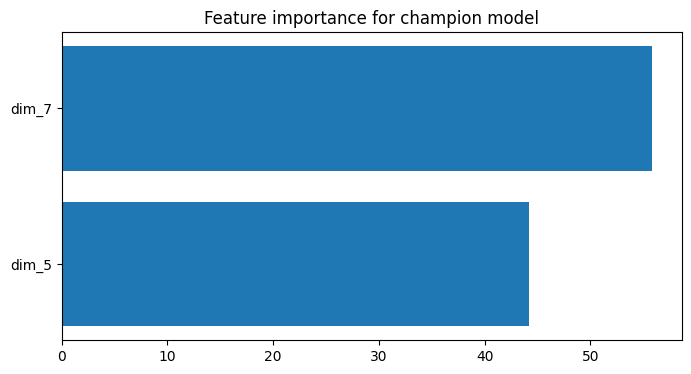

In [121]:
import dalex
# Create an explainer object
exp = dalex.Explainer(model, X_train_scaled_df, y_train, label='Champion Model')

# Calculate feature importance
feature_importance = exp.model_parts()
feature_importance.plot(max_vars=27)